In [5]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from random import shuffle

from random import sample

In [7]:
# Simulate frequency vectors. 
# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 150

import itertools as it
n= 500

# Vary a (beta distribution parameter).
a_range= np.linspace(1,2,15)
a_set= [i for i in a_range for _ in range(n)]

# vary b.
b_range= np.linspace(0.1,.4,15)
b_set= [i for i in b_range for _ in range(n)]

## length of haplotypes to extract.
L_set= [L] * n * 15


background_1= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background_1.shape[0]):
    
    probs= beta.rvs(background_1[k,0], background_1[k,1], size=int(background_1[k,2]))
    probs[(probs > 1)]= 1
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)

In [8]:
n_comp = 100

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.018; PC2: 0.008; PC3: 0.008; PC4: 0.008; PC5: 0.008; PC6: 0.008; PC7: 0.008; PC8: 0.008; PC9: 0.008; PC10: 0.008; PC11: 0.008; PC12: 0.008; PC13: 0.008; PC14: 0.008; PC15: 0.008; PC16: 0.008; PC17: 0.008; PC18: 0.008; PC19: 0.008; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.007; PC29: 0.007; PC30: 0.007; PC31: 0.007; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.007; PC45: 0.007; PC46: 0.007; PC47: 0.007; PC48: 0.007; PC49: 0.007; PC50: 0.007; PC51: 0.007; PC52: 0.007; PC53: 0.007; PC54: 0.007; PC55: 0.007; PC56: 0.007; PC57: 0.007; PC58: 0.007; PC59: 0.007; PC60: 0.007; PC61: 0.007; PC62: 0.007; PC63: 0.007; PC64: 0.007; PC65: 0.007; PC66: 0.007; PC67: 0.007; PC68: 0.007; PC69: 0.007; PC70: 0.006; PC71: 0.006; PC72: 0.006; PC73: 0.006; PC74: 0.006; PC75: 0.006; PC76: 0.006; PC77: 0.006; PC78: 0.

In [10]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background_1[k,0],background_1[k,1],background_1[k,2], k) for k in range(background_1.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


In [11]:
#### calculating Fsts between populations.
Pops= [395,390]
Sizes= [80,100]

def return_fsts(vector_lib,pops):
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1044


pops       fst
0  (395, 390)  0.104428

In [12]:
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [13]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
target= [0,1]


labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(-10,10,.05):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]
    
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



In [14]:
pop_diff= [x for x in range(len(labels)) if labels[x] == (0,1)]

fig_data= [go.Scatter(
x= [Distances_crawl[x] for x in pop_diff],
y= [Fsts_crawl[x] for x in pop_diff],
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [15]:

def extract_profiles(global_data,target_ind_dict):
    ## estimate the bandwith
    params = {'bandwidth': np.linspace(np.min(global_data), np.max(global_data),20)}
    grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
    
    cluster_profiles= {x:[] for x in target_ind_dict.keys()}
    
    
    ## perform MeanShift clustering.
    combine= {}
    for bull in target_ind_dict.keys():
        Quanted_set= global_data[target_ind_dict[bull],:]
        grid.fit(Quanted_set)
        kde = grid.best_estimator_

        P_dist = kde.score_samples(Quanted_set)
        Fist = kde.score_samples(global_data)

        ## Normalizing log-likelihood estimates by those of the reference set and extracting their cdf.
        Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
        cluster_profiles[bull].append(Fist)

    
    return cluster_profiles
    


def Merge_class2(Ref_profiles,target_indx,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        print(CHR)
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        print("number of reference populations: {0}".format(N_pops))
        #Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        #Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for bl in Likes.keys():
            maxim= []
            
            
            for acc in focus_indicies:
                Test= [Likes[bl][x][0][acc] for x in sorted(Likes[bl].keys())]
                
                Guys= [Likes[bl][x][0][acc] for x in sorted(Likes[bl].keys())]
                
                if max(Test) <= X_threshold:
                    maxim.append(N_pops)
                else:
                    Consex = [x for x in it.combinations(range(N_pops),2)]
                    CL = []
                    for j in Consex:
                        Diff = [Guys[i] for i in j]
                        
                        if Guys.index(max(Guys)) not in j or len([x for x in Diff if x < X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = int(len([x for x in Diff if x <= Diff_threshold]) == 1)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        maxim.append(7)
                    if len(CL) == 1:
                        maxim.append(sum(CL[0]) + N_pops)
                    else:
                        maxim.append(Guys.index(max(Guys)))
            
            Topo.append([maxim[c] + 1 for c in range(len(maxim))]) 
        
        Topo = np.array(Topo)
        print(Topo.shape)
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome



def Merge_class(Ref_profiles,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        
        Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for acc in focus_indicies:
            Guys = np.array([Likes[x][:,acc] for x in Pop_labels])
            Guys = np.nan_to_num(Guys)
            Guys = [[[y,0][int(y<=X_threshold)] for y in x] for x in Guys]
            
            Test = [int(x <= X_threshold) for x in np.amax(np.array(Guys),axis = 0)]     
            
            #
            Guys = np.array(Guys).T
            
            maxim = np.argmax(Guys,axis = 1)
            where_X = [x for x in range(Guys.shape[0]) if Test[x] == 1]
            
            #
            Consex = [x for x in it.combinations(range(N_pops),2)]
            if Consex:
                for h in range(len(maxim)):
                    CL = []
                    for j in Consex:
                        Diff = Guys[h,j]
                        if maxim[h] not in j or len([x for x in Diff if x < X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = int(len([x for x in Diff if x <= Diff_threshold]) == 1)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        maxim[h] = 7
                    if len(CL) == 1:
                        maxim[h] = sum(CL[0]) + N_pops
            
            maxim[where_X] = N_pops
            
            if not Consex:
                for h in range(len(maxim)):
                    #maxim[h] = int(10*Guys[h,0])
                    maxim[h]= int(Guys[h,0] <= X_threshold)
            
            
            Topo.append(maxim + 1)
        
        
        Topo = np.array(Topo).T
        
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome


def compress_ideo(df,chromosome_list):
    
    new_set = []
    
    for CHR in range(len(chromosome_list)):
        
        Chr = int(re.search('Region_(.+?)_',chromosome_list[CHR]).group(1))
        sub = df[df.chrom == chromosome_list[CHR]]
        Coordinates = sorted(sub.start)
        Size = sub.shape[0]
        start = min(df.start)
        First = sub.gieStain.iloc[0]
        for index in range(len(Coordinates)):
            row = sub[sub.start == Coordinates[index]]
            if index == 0:
                continue
            if index == (Size - 1):
                if row.gieStain.iloc[0] == First:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                else:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
            else:
                if row.gieStain.iloc[0] == First:
                    continue
                else:
                    new_set.append([chromosome_list[CHR],start,row.start.iloc[0]-1,First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
    
    new_set = pd.DataFrame(new_set,columns = ['chrom', 'start', 'end', 'gieStain'])
    return new_set


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


def return_ideogram(ideo, out= True):
    # Height of each ideogram
    chrom_height = 1

    # Spacing between consecutive ideograms
    chrom_spacing = 0

    # Height of the gene track. Should be smaller than `chrom_spacing` in order to
    # fit correctly
    gene_height = 0.0

    # Padding between the top of a gene track and its corresponding ideogram
    gene_padding = 0.0


    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing



    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing
    

    # Colors for different chromosome stains
    color_lookup = {
        'red': [255, 0, 0],
        'yellow': [255, 255, 0],
        'blue': [0, 0, 255],
        'orange': [255, 165, 0],
        'green': [50, 205, 50],
        'black': [0, 0, 0],
        'purple': [128, 0, 128],
        'silver': [211, 211, 211],
    }

    # Add a new column for colors
    
    ideo['colors'] = ideo['gieStain'].apply(lambda x: tuple([round(y / float(255),1) for y in color_lookup[x]]))
    # Add a new column for width
    ideo['width'] = ideo.end - ideo.start

    # Width, height (in inches)
    figsize = (10, 30)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Now all we have to do is call our function for the ideogram data...
    print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, edgecolors=None, linewidths= 0):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_xticks([x for x in range(min(ideo.start),max(ideo.end),int(10000))])
    ax.set_xticklabels([round(x / float(10000),3) for x in range(min(ideo.start),max(ideo.end),int(10000))])
    plt.xticks(fontsize = 5,rotation = 90)
    ax.tick_params(axis = 'x',pad = 10)

    ax.tick_params(axis='y', which='major', pad=30)
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize = 5)
    ax.axis('tight')
    if out == True:
        plt.savefig('Ideo_step_' + '_OutlierTh' + str(Outlier_threshold) + '_Z' +str(Comparison_threshold)+ '.png',bbox_inches = 'tight')
    return fig




In [16]:
def OriginbySNMF(Geno_Q,t):
    """
    Classes individuals according to Group assignment by SNMF
    using user provided threshold (.8 advised). returns dict.
    """
    Geneo = open(Geno_Q,"r")
    Ind = 0
    Groups = recursively_default_dict()
    for line in Geneo:
        line= line.split()
        line= [float(x.strip("\n")) for x in line]
        line= [x / sum(line) for x in line]
        if Ind == 0:
            Groups = {x:[] for x in range(len(line) + 1)}
        bagged = 0
        for value in range(len(line)):
            if line[value] >= t:
                Groups[value].append(line)
                bagged += 1
        if bagged == 0:
            Groups[len(line)].append(line)
        Ind += 1
    return Groups



Geno_Q = "sNMF_out3K.Q"
Geneo = OriginbySNMF(Geno_Q,.9)


In [17]:
######## Simple two way admixture


In [18]:
Sizes= [100,100]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
    } for x in range(len(Sizes))
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
"""
Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}
"""

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


In [19]:
labels= [0,1]
target= [0,1]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 1e-3

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(-10,10,.05):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)

    data= []
    local_labels= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,target_indx)
    
    ### get population fsts
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles


Windows= {1:Windows}

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

KeyboardInterrupt: 

In [25]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= [] 
chromosomes= [1]

Comparison_threshold= 1
Outlier_threshold= 1e-4

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


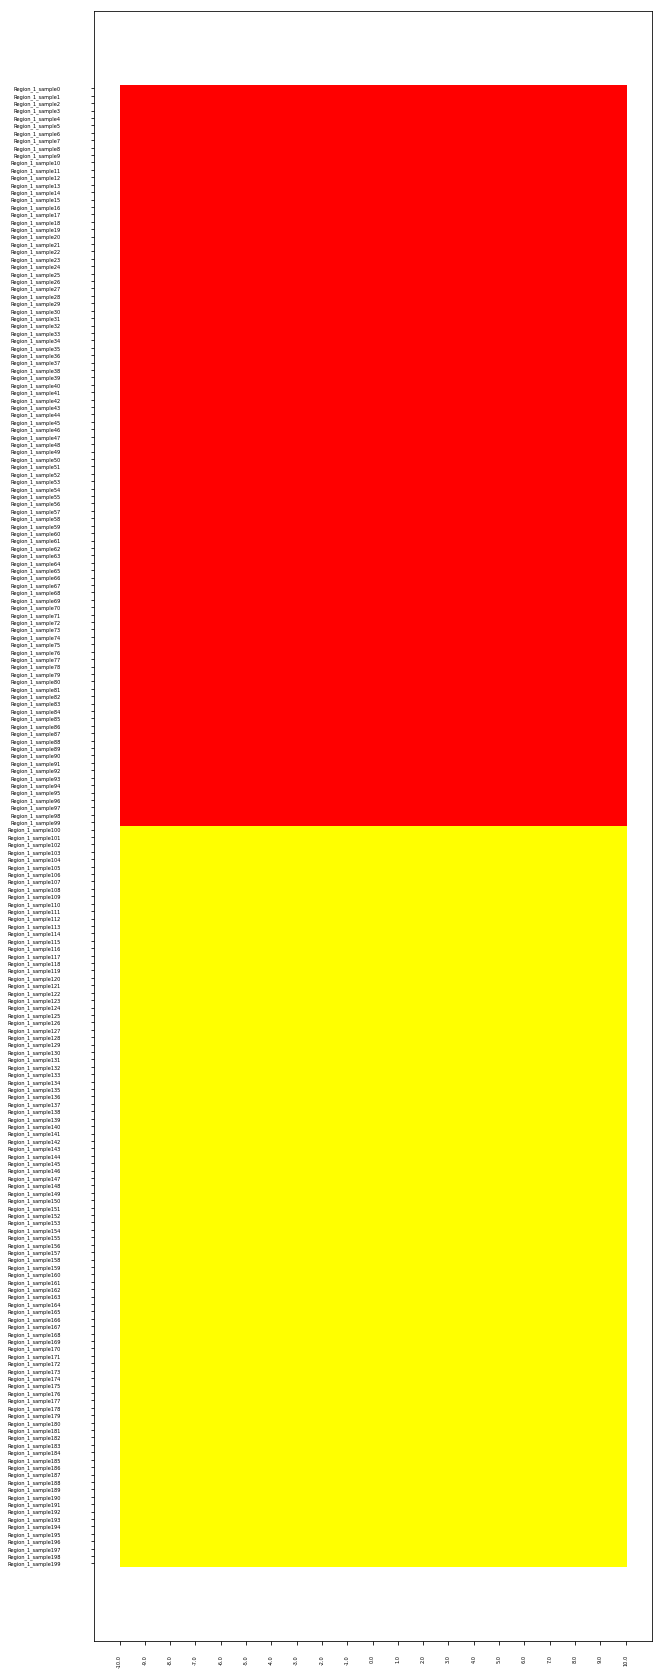

In [26]:
fig= return_ideogram(ideo,out= True)


In [27]:
###### save haplotypes to KDE script format:

## geno file
## bim-like marker file
## bam ID file
## Reference ID file
## admx ID file.

Refs= [0,1]
Admx= [3]
Home= 'LAMP-HAP_test'
Home_kde= 'KDE_sim'


def kde_input(Out, Refs, Admx, haplotypes, Home):
    prefix= 'sample_'
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_markers.txt"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(chromosomes[0]) + '\t' + '\t'.join(['0']*2) + '\t' + str(s) + '\tA\tC\t' + '\n')
    posfile.close()
    
    ## geno file
    Geno_out= Home + '/kde_test.geno'
    os.makedirs(os.path.dirname(Geno_out), exist_ok=True)
    Geno_out= open(Geno_out,'w')
    
    #Geno_store= np.array([haplotypes[x] for x in Whose]).T
    
    for locus in range(len(Snps)):
        for acc in Whose:
            Geno_out.write(str(haplotypes[acc][locus] * 2))
        Geno_out.write('\n')
        
    Geno_out.close()
    
    
    ## fam file
    fam_file= Home + '/kde_test.fam'
    os.makedirs(os.path.dirname(fam_file), exist_ok=True)
    Output_fam= open(fam_file,'w')
    
    for acc in Whose:
        ID= prefix + str(Whose[acc])
        Output_fam.write(ID + '\t' + ID + '\n')
    
    
    ## reference index file
    ref_file= Home + "/test_ref.txt"
    os.makedirs(os.path.dirname(ref_file), exist_ok=True)
    Output_ref= open(ref_file,'w')
    
    ## admixed index file
    admx_file= Home + "/test_admx.txt"
    os.makedirs(os.path.dirname(admx_file), exist_ok=True)
    Output_admx= open(admx_file,'w')
    
    d= 0
    
    for pop in Refs:
        
        for acc in label_indicies[pop]:
            ID= prefix + str(Whose[acc])
            ## write to ref
            Output_ref.write(str(pop) + '\t' + ID + "\n")
            
    Output_ref.close()
    
    for pop in Admx:
        
        for acc in label_indicies[pop]:
            ID= prefix + str(Whose[acc])
            ## write to ref
            Output_admx.write(str(pop) + '\t' + ID + "\n")
            
    Output_admx.close()



import os
#kde_input(Out,Refs,Admx,haplotypes,Home_kde)



adding ideograms...


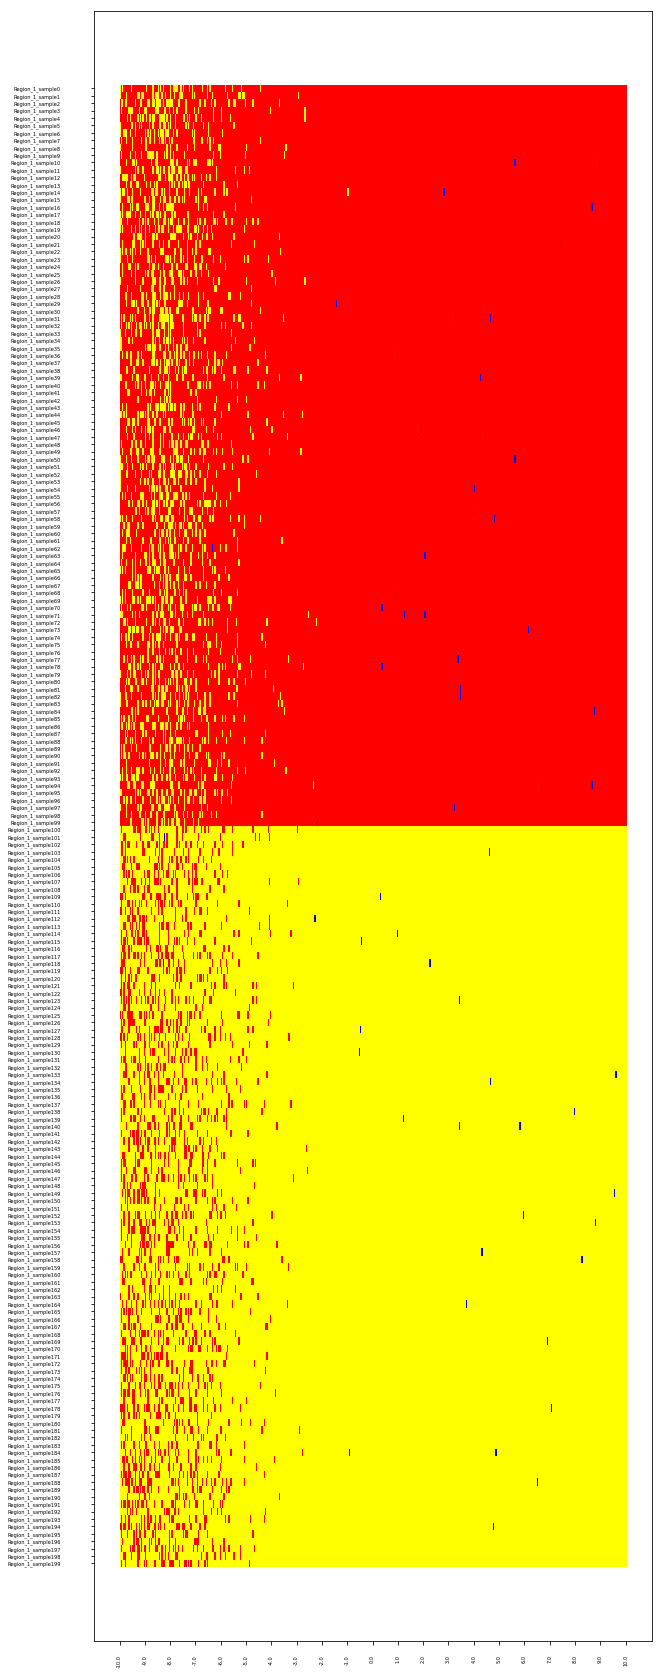

In [28]:
#### KDE no filter

focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 1
Outlier_threshold= 1e-4

color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)

fig= return_ideogram(ideo_kde)


In [29]:
wind= []
Proportions= []
labs= []
for w in Windows[1].keys():
    for combo in it.combinations(Windows[1][w].keys(),2):
        diffs= [abs(Windows[1][w][combo[0]][x] - Windows[1][w][combo[1]][x]) for x in range(len(Windows[1][w][combo[1]]))]
        
        Proportions.append(np.mean(diffs))
        labs.append(tuple([x+1 for x in combo]))
        wind.append(w)


In [30]:
coords= {z:[x for x in range(len(labs)) if labs[x] == z] for z in list(set(labs))}


fig_data= [go.Scatter(
y= [Proportions[x] for x in coords[i]],
x= [wind[x] / 1e4 for x in coords[i]],
mode= 'lines',
name= ' pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'average KDE score differences',
    yaxis=dict(
        title='Difference'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [31]:

Error_rate= []
where= []

for bl in Blocks[1].keys():
    non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks2[1][bl][x] != len(labels) + 1]
    misshaps= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] - 1 in labels]
    rate= 1 - len(misshaps) / float(len(non_outlier))
    Error_rate.append(rate)
    where.append(bl)

fig_data= [go.Scatter(
x= [x / float(1e4)  for x in where],
y= Error_rate,
mode= 'lines'
) 
]

layout = go.Layout(
    title= 'Successful classifications as a function of X',
    yaxis=dict(
        title='Proportion of correctly classified windows',
        range=[0,1]),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [32]:
[Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2]
target

[0, 1]

In [61]:
fig_data= [go.Scatter(
x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
y= Error_rate,
mode= 'lines'
) 
]

layout = go.Layout(
    title= 'KDE robustness',
    yaxis=dict(
        title='Proportion of correct classification by window.',
        range=[0,1.2]),
    xaxis=dict(
        title='Fst')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

adding ideograms...


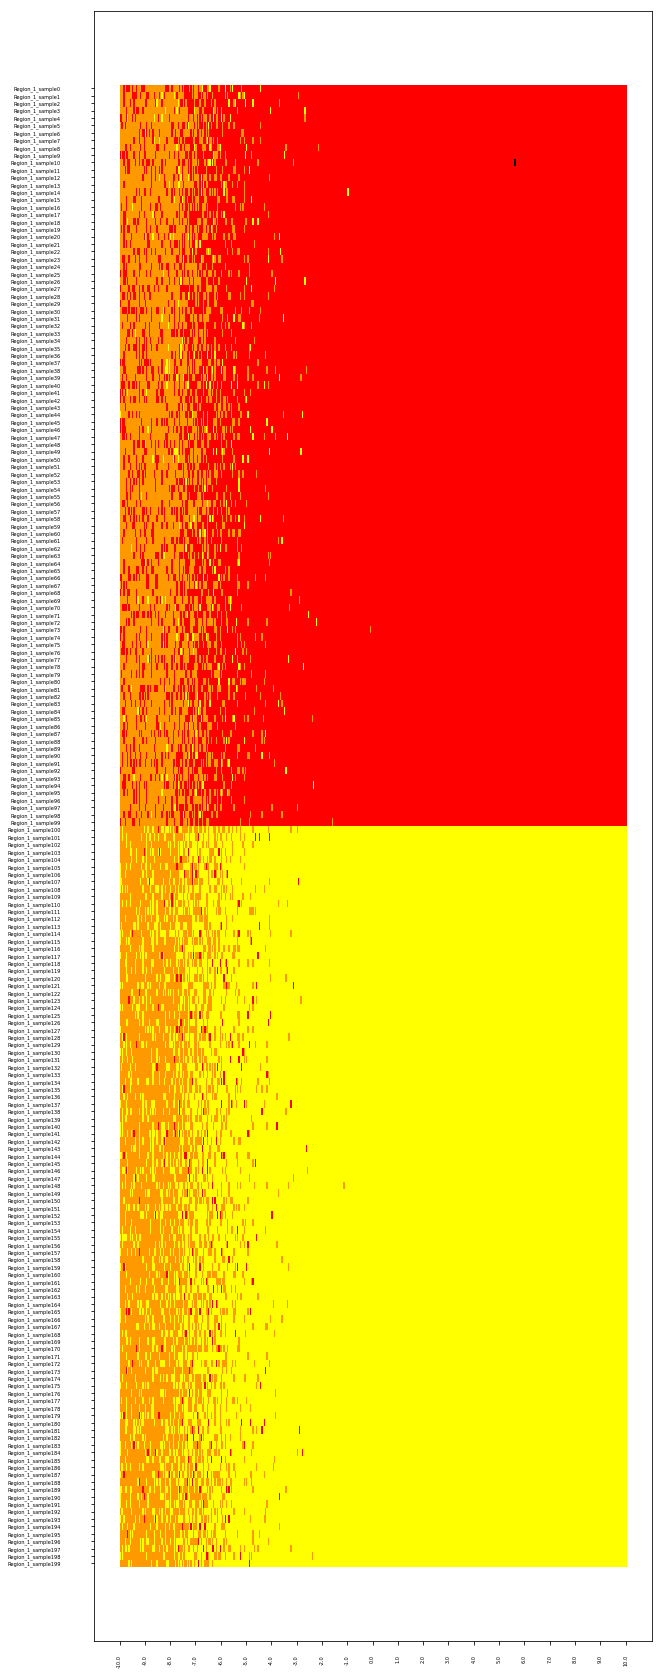

In [35]:
#### KDE filter

focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 4
Outlier_threshold= 1e-7
color_ref= ['red','yellow','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks3 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks3[Chr][bl][here] - 1]] for bl in sorted(Blocks3[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)

fig= return_ideogram(ideo_kde)


In [36]:
### relation between fst and proportion of a population

In [39]:

Error_rate= []
where= []

for bl in Blocks[1].keys():
    non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks3[1][bl][x] != len(labels) + 1]
    misshaps= [x for x in range(len(Blocks3[1][bl])) if Blocks[1][bl][x] != Blocks3[1][bl][x] and Blocks3[1][bl][x] - 1 in labels]
    rate= 1 - len(misshaps) / float(len(non_outlier))
    Error_rate.append(rate)
    where.append(bl)

fig_data= [go.Scatter(
x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
y= Error_rate,
mode= 'lines'
) 
]

layout = go.Layout(
    title= 'Successful classifications as a function of X',
    
    yaxis=dict(
        title='Proportion of correctly classified windows',
        range= [0,1]),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [40]:
#### test mislabelled windows vs. proportion of intermediately classified windows:
Fst_c= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2]

Errors_P= []
Interns_P= []
Corrected_P= []

Errors= []
Internal_rate= []
Fsts= []
perc_inter= []

for lvl in np.arange(1.2,10,.1):
    
    BlocksV = Merge_class(Windows,focus_indexes,Out,lvl,Outlier_threshold)

    Error_rate= []
    Int_rate= []
    
    Correction= []
    Ori_error= []
    Unnec= []
    
    P_Dpos= []
    
    for bl in Blocks[1].keys():
        non_outlier= [x for x in range(len(Blocks[1][bl])) if Blocks2[1][bl][x] != len(labels) + 1]
        Origin_misshaps= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] - 1 in labels]
        
        misshaps= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != BlocksV[1][bl][x] and BlocksV[1][bl][x] - 1 in labels]
        Intermediates= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != BlocksV[1][bl][x] and BlocksV[1][bl][x] - 1 > len(labels)]
        
        Corrected= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] != Blocks2[1][bl][x] and Blocks2[1][bl][x] - 1 in labels and x in Intermediates]
        Unnecessary= [x for x in Intermediates if x not in Origin_misshaps]
        
        miss_prop= 1 - len(misshaps) / float(len(non_outlier))
        int_prop= 1 - (len(Intermediates)) / float(len(non_outlier))
        
        Int_rate.append(len(Intermediates))
        Error_rate.append(len(misshaps))
        Correction.append(len(Corrected))
        Ori_error.append(len(Origin_misshaps))
        Unnec.append(len(Unnecessary))
        
        Internal_rate.append(int_prop)
        Errors.append(miss_prop)
    
    Fsts.extend(Fst_c)
    Corrected_P.append(sum(Correction) / float(sum(Ori_error)))
    Errors_P.append(sum(Error_rate) / ((len(focus_indexes) * len(Blocks[1].keys())) - sum(Int_rate)))
    Interns_P.append(sum(Unnec) / float(sum(Int_rate)))
    perc_inter.append(sum(Int_rate) / (len(focus_indexes) * len(Blocks[1].keys())))


KeyboardInterrupt: 

In [41]:
test_stat= [float(perc_inter[x]) * Interns_P[x] for x in range(len(Interns_P))]

fig_data= [go.Scatter(
x= np.arange(1.2,10,.2),
y= Internal_rate,
mode= 'lines'
)]


layout = go.Layout(
    title= 'Total intermediate assignment as a function of ratio threshold',
    yaxis=dict(
        title='Intermdiate assignment'),
    xaxis=dict(
        title='Proportion threshold'),
)



fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [42]:
fig_data= [go.Scatter3d(
        x= np.arange(1.2,10,.2),
        y= Internal_rate,
        z = Corrected_P,
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [ ]:
######## Two way admixture with outliers

In [43]:
Sizes= [100,100]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes))] for y in range(Sizes[x])
    } for x in range(len(Sizes))
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]
"""
Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}
"""

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


In [44]:
labels= [0,1]
target= [0,1]
refs= [0]

Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 1e-3

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in refs}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(-10,10,.05):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]

    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)

    data= []
    local_labels= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,target_indx)
    
    ### get population fsts
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles


Windows= {1:Windows}

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

In [45]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


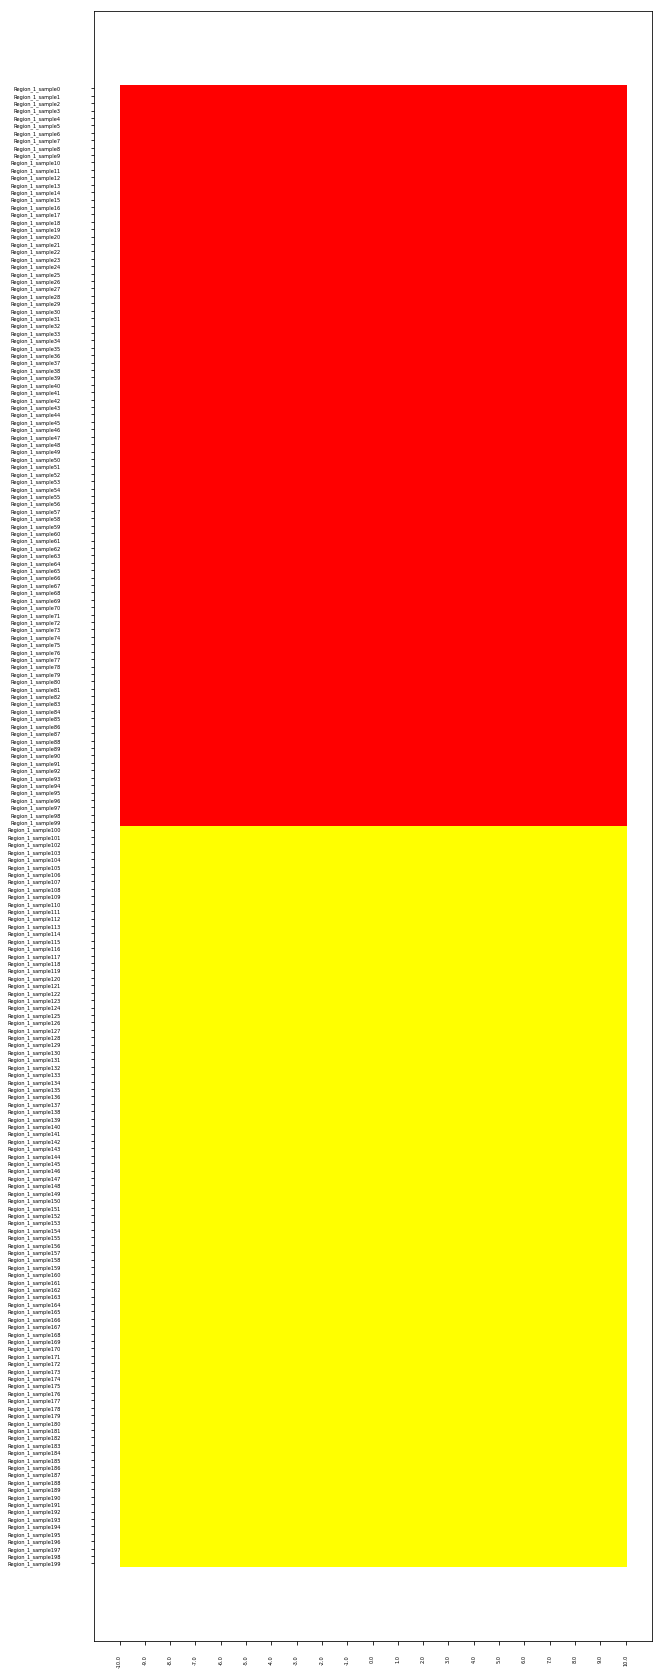

In [46]:

Outlier_threshold= 1e-4
Comparison_threshold= 1

fig= return_ideogram(ideo)


adding ideograms...


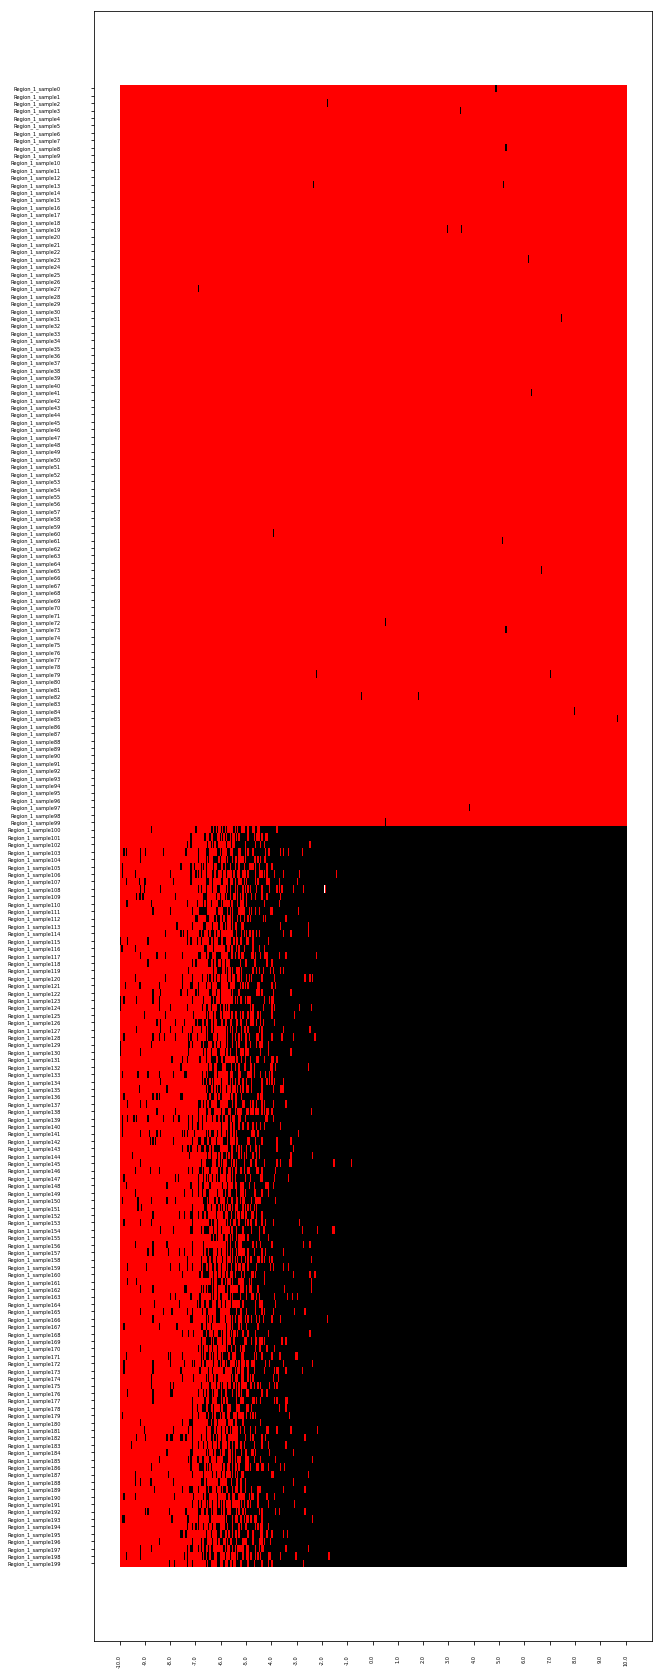

In [58]:
#### KDE no filter
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 1
Outlier_threshold= 1e-4

color_ref= ['red','black','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)

fig= return_ideogram(ideo_kde)


In [59]:

Error_rate= []
where= []
outlier_present= []

for bl in Blocks[1].keys():
    all_blue= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] == 2]
    if len(all_blue) == 0:
        outlier_present.append('no outliers')
        rate= 1
    else:
        outlier_blues= [x for x in all_blue if Blocks2[1][bl][x] == len(labels)]
        rate= len(outlier_blues) / float(len(all_blue))
        outlier_present.append('at least one outlier')
    Error_rate.append(rate)
    where.append(bl)


In [60]:
fig_data= [go.Scatter(
x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
y= Error_rate,
mode= 'markers'
) 
]

layout = go.Layout(
    title= 'KDE robustness, outlier_threshold= ' + str(round(Outlier_threshold,7)),
    yaxis=dict(
        title='Proportion of correct classification by window.'),
    xaxis=dict(
        title='Fst')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [53]:
#### KDE 

focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-6
color_ref= ['yellow','red','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)



adding ideograms...


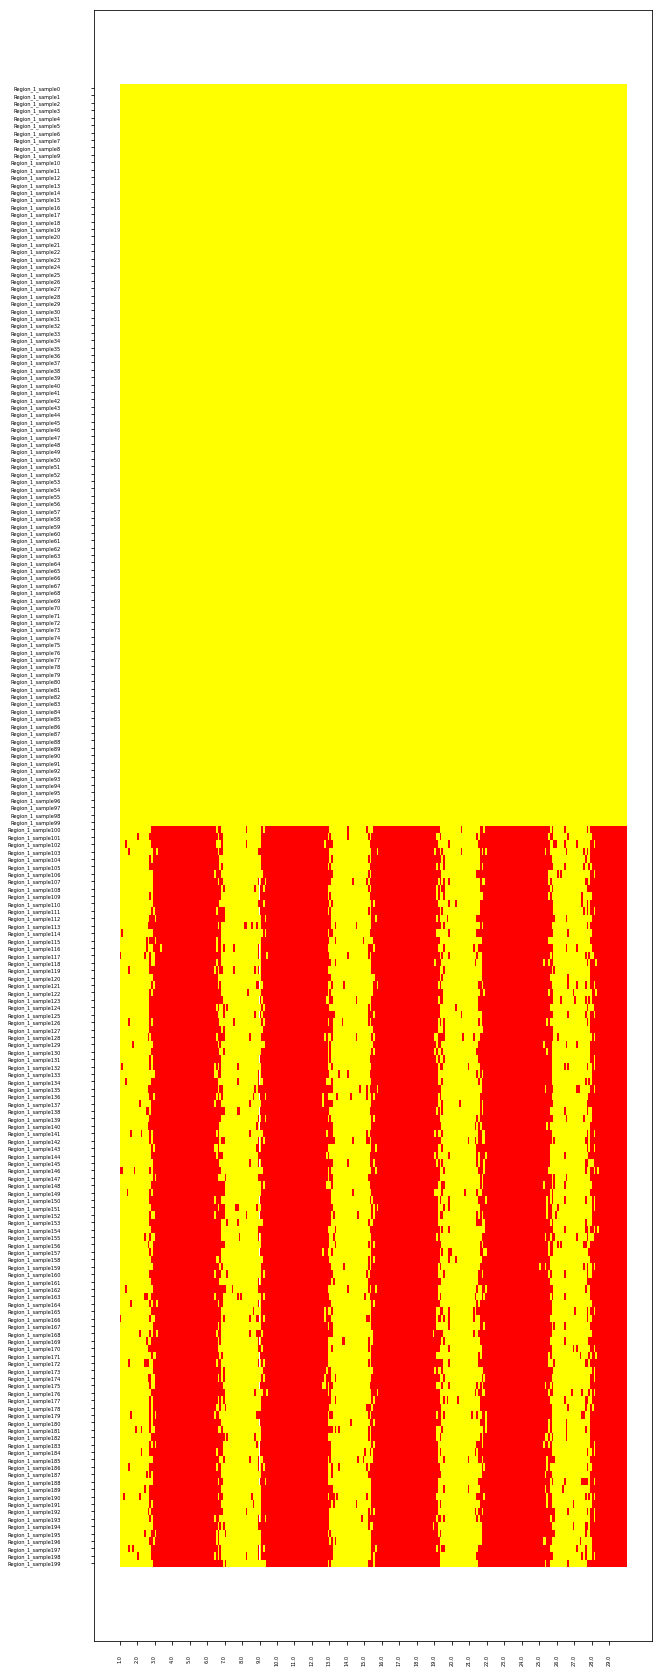

In [82]:
fig= return_ideogram(ideo_kde)

In [86]:

Error_rate= []
where= []
outlier_present= []

for bl in Blocks[1].keys():
    all_blue= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] == 2]
    if len(all_blue) == 0:
        outlier_present.append('no outliers')
        rate= 1
    else:
        outlier_blues= [x for x in all_blue if Blocks2[1][bl][x] == len(labels)]
        rate= len(outlier_blues) / float(len(all_blue))
        outlier_present.append('at least one outlier')
    Error_rate.append(rate)
    where.append(bl)

fig_data= [go.Scatter(
x= [where[x] for x in range(len(where)) if outlier_present[x] == i],
y= [Error_rate[x] for x in range(len(Error_rate)) if outlier_present[x] == i],
    mode= 'lines'
) for i in list(set(outlier_present))
]

layout = go.Layout(
    title= 'Successful classifications as a function of X, ',
    
    yaxis=dict(
        title='Proportion of correctly classified windows',
        range= [0,1]),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [87]:
fig_data= [go.Scatter(
x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
y= Error_rate,
mode= 'markers'
) 
]

layout = go.Layout(
    title= 'KDE robustness, outlier_threshold= ' + str(round(Outlier_threshold,7)),
    yaxis=dict(
        title='Proportion of correct classification by window.'),
    xaxis=dict(
        title='Fst')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [ ]:
######## Two way admixture with varying frequency of introgression

In [69]:
Geno_Q = "sNMF_out3K.Q"
Geneo = OriginbySNMF(Geno_Q,.9)

Sizes= [100,100,0,0]

Origins= {}

### set up an actual reference for the first pop.

Origins[0] = {y:[1,0,0] for y in range(Sizes[0])}
Origins[1] = {y:[0,1,0] for y in range(Sizes[1])}

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in sorted(Origins.keys()):
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

#####

In [110]:
from math import floor
X= []
Y= []



for x in np.arange(-10,10,.05):
    X.append(x + 10)
    #Y.append(floor(x / np.pi) * .005)
    Y.append(floor((x + 10) / 2.5) / 100)

fig_data= [go.Scatter(
x= X,
y= Y,
mode= 'markers'
) 
]

layout = go.Layout(
    title= 'outlier frequency steps',
    yaxis=dict(
        title= 'Frequency'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [111]:
##### 
# the new parameter here is f_pop1: the step at which we will increase the frequency of pop1 material among pop0 accessions.
f_pop1= .01

#####
labels= [0,1,2]
target= [0,1]
Chr= 1
color_ref= ['yellow','blue','red','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']
N_pops= len(Pops)

COp= 1

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in [0]}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(-10,10,.05):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]
    
    #coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    coords[target[0]] = coords[target[0]] + [angle / 10 * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    ##### modify the transition probabilities of pop1 samples as in the above plot:
    for x in Origins[0].keys():
        #Origins[0][x][1]= floor(angle / np.pi) * f_pop1
        #Origins[0][x]= [y / sum(Origins[0][x]) for y in Origins[0][x]]
        Origins[0][x][1]= floor((angle + 10) / 2.5) / 100
        Origins[0][x][0]= 1 - floor((angle + 10) / 2.5) / 100
        
        
    
    data= []
    local_labels= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,target_indx)
    
    ### get population fsts
    Pairwise= return_fsts2(new_freqs)
    Fst_labels.extend(Pairwise.pops)
    
    Fst_crawl.extend(Pairwise.fst)
    
    Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles


Windows= {1:Windows}

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\j

In [112]:
transition_p

[0, 1, 0]

In [113]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
Comparison_threshold= 5
Outlier_threshold= 1e-4


import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


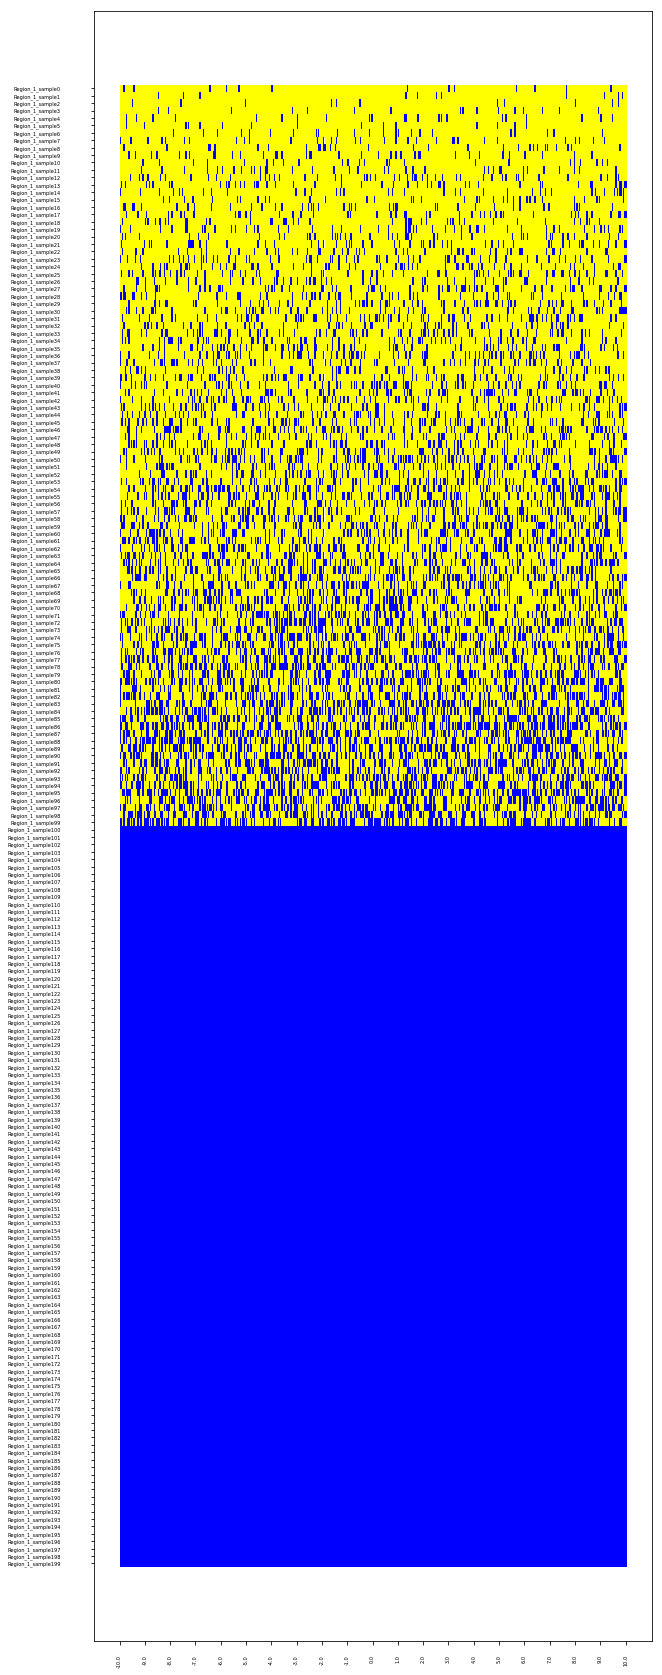

In [114]:
fig= return_ideogram(ideo)

1
number of reference populations: 1
adding ideograms...


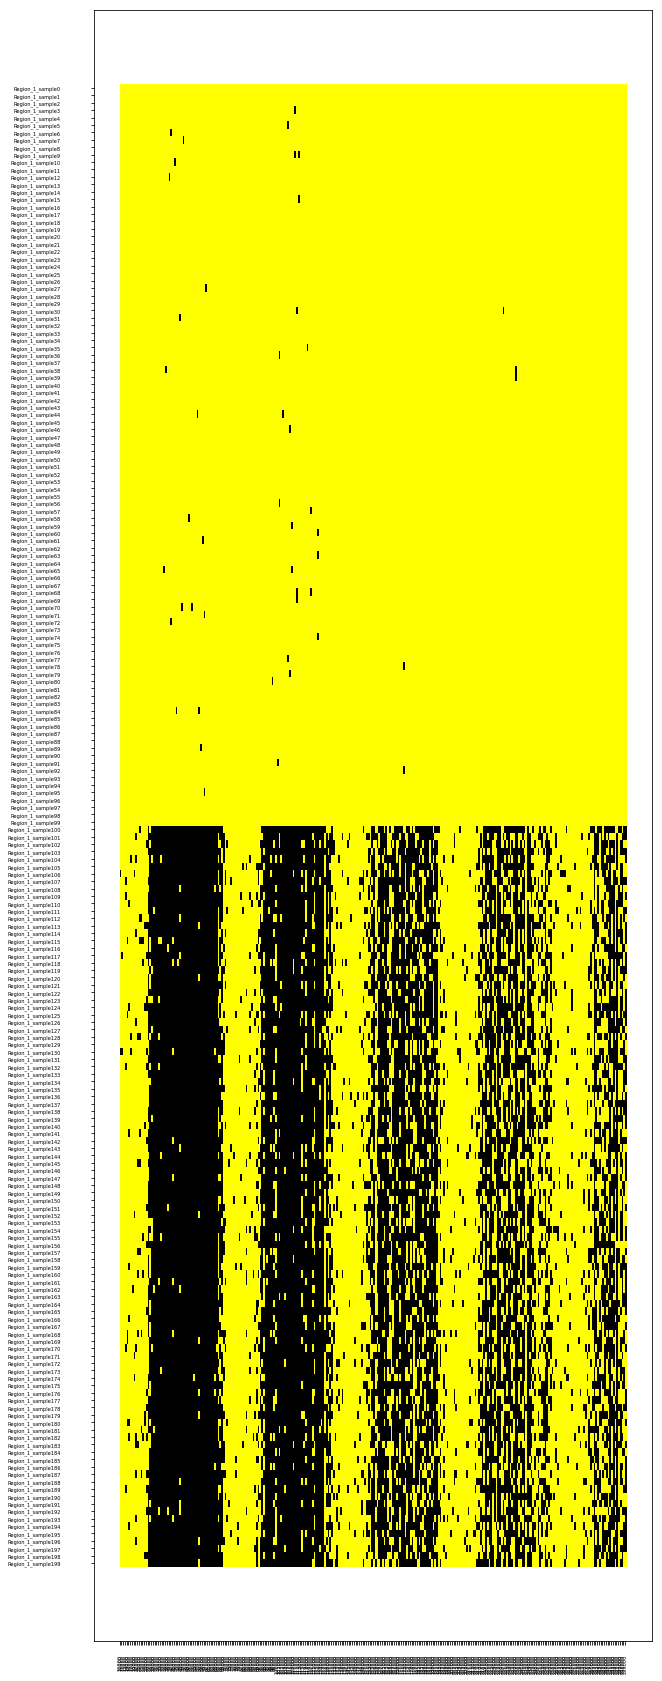

In [23]:
#### KDE no filter

focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-4
color_ref= ['yellow','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)

fig= return_ideogram(ideo_kde)

In [24]:
Error_rate= []
where= []
outlier_present= []

for bl in Blocks[1].keys():
    all_blue= [x for x in range(len(Blocks[1][bl])) if Blocks[1][bl][x] == 2]
    if len(all_blue) == 0:
        outlier_present.append('no outliers')
        rate= 1
    else:
        outlier_blues= [x for x in all_blue if Blocks2[1][bl][x] == 2]
        rate= len(outlier_blues) / float(len(all_blue))
        outlier_present.append('at least one outlier')
    Error_rate.append(rate)
    where.append(bl)

Fsts_now= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2]

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunky= [x for x in chunks(Error_rate,29)]

Fst_set= np.linspace(min(Fsts_now),max(Fsts_now),29)

churro= [[x[y] for y in range(29)] for x in chunky]
[len(x) for x in churro]

[29, 29, 29, 29, 29, 29, 29, 29, 29, 29]

In [63]:
paysage= np.array([[Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
                  [floor(angle / np.pi) * f_pop1 for angle in np.arange(1,30,.1)],
                  Error_rate]).T


fst_above2= [x for x in range(paysage.shape[0]) if paysage[x,0] > .03]
fig_data=[]

for fst in sorted(list(set(paysage[:,1]))):
    trace0 = go.Box(
        y=paysage[[x for x in range(paysage.shape[0]) if paysage[x,1] == fst and paysage[x,0] > .03],2],
        name = 'freq {}'.format(fst)
    )
    fig_data.append(trace0)

fig_surf= [go.Surface(
    y= np.linspace(min(Fsts_now),max(Fsts_now),29),
    x= list(set([floor(angle / np.pi) * f_pop1 for angle in np.arange(1,30,.1)])),
    z= churro
)]

###
params = {'bandwidth': np.linspace(np.min(paysage),np.max(paysage),10)}
grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)

## perform MeanShift clustering.
grid.fit(paysage)
kde = grid.best_estimator_

smoothed_grid= kde.sample(1000)

fig_mesh= [go.Mesh3d(
    x= paysage[:,0],
    y= paysage[:,1],
    z= paysage[:,2],
    opacity= .6,
    color= paysage[:,2],
    colorbar= go.ColorBar(
            title= 'colorbar'
        ),
    colorscale= 'Viridis'
)
]


layout = go.Layout(
    title= 'Accuracy as a function of alien inclusion frequency. Fs > .03',
    
    yaxis=dict(
        title='Proportion of correctly classified windows',
        range= [0,1]),
    xaxis=dict(
        title='X')
)

df3=pd.DataFrame({
    'x':[1,2,3,4,5],
    'y':[10,20,30,20,10],
    'z':[[5,4,3,2,1]] * 5
})

trace0= go.Surface(x=df3['x'], y=df3['y'], z=df3['z'])
data0=[trace0]


fig= go.Figure(data=fig_data,layout= layout)
iplot(fig)

In [41]:


fig_data= [go.Scatter3d(
    x= [Fst_crawl[x] for x in range(len(Fst_labels)) if len([y for y in Fst_labels[x] if y in target]) == 2],
    y= Error_rate,
    type= 'scatter',
    mode= 'markers'
)
]



layout = go.Layout(
    title= 'Successful classifications as a function of X',
    
    yaxis=dict(
        title='Proportion of correctly classified windows',
        range= [0,1]),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data,layout= layout)
iplot(fig)

In [ ]:
######## Three way admixture

In [27]:
#### let's create our populations
## we'll sample randomly from each of the set created from the admixture analysis.
Sizes= [120,80,100,70]

Origins= {x: sample(Geneo[x], Sizes[x]) for x in Geneo.keys()}

Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


In [167]:
labels= [0,1,2]
target= [1,2]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 5e-2

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(1,10,.1):
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)

    data= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,target_indx)
    
    ### store stuff.
    Windows[bl]= profiles


Windows= {1:Windows}

In [57]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


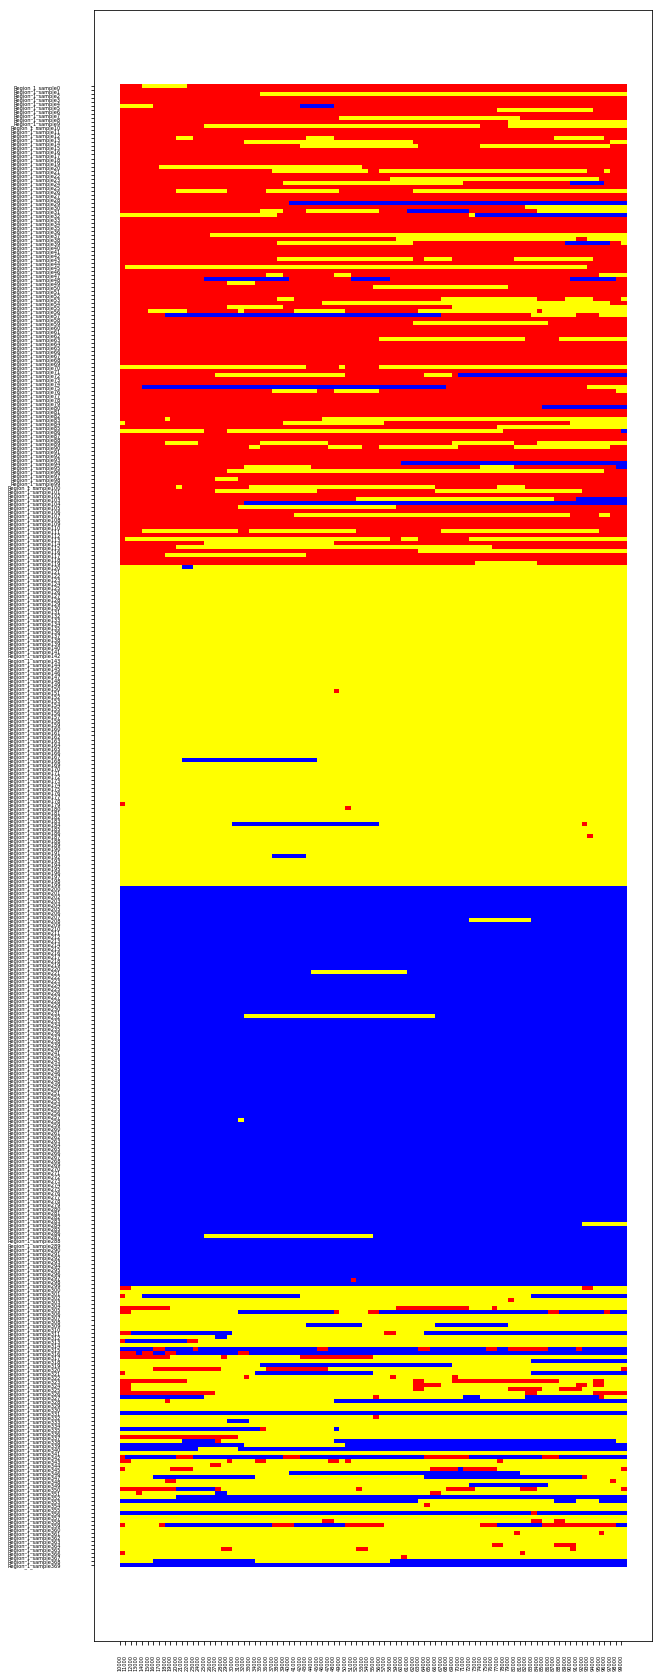

In [58]:
fig= return_ideogram(ideo)


In [149]:

def Merge_class2(Ref_profiles,target_indx,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        print(CHR)
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        print("number of reference populations: {0}".format(N_pops))
        #Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        #Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for bl in Likes.keys():
            maxim= []
            
            CDF= {x:scipy.stats.norm(np.mean([Likes[bl][x][0][y] for y in target_indx[x]]),
                                     np.std([Likes[bl][x][0][y] for y in target_indx[x]])).cdf([y for y in Likes[bl][x][0]]) for x in Likes[bl].keys()
                 }
            
            PDF= {x:scipy.stats.norm(np.mean([Likes[bl][x][0][y] for y in target_indx[x]]),
                                     np.std([Likes[bl][x][0][y] for y in target_indx[x]])).pdf([y for y in Likes[bl][x][0]]) for x in Likes[bl].keys()
                 }
            
            for acc in focus_indicies:
                Test= [CDF[x][acc] for x in sorted(Likes[bl].keys())]
                Test= np.nan_to_num(Test)
                Guys= [CDF[x][acc] for x in sorted(Likes[bl].keys())]
                Guys= np.nan_to_num(Guys)
                
                max_i= [x for x in range(N_pops) if Guys[x] == max(Guys)][0]
                classy= max_i
                
                if max(Test) <= X_threshold:
                    classy= N_pops
                else:
                    Consex = [x for x in it.combinations(range(N_pops),2)]
                    CL = []
                    for j in Consex:
                        Diff = [Guys[i] for i in j]
                        
                        if max_i not in j or len([x for x in Diff if x <= X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = int(len([x for x in Diff if x <= Diff_threshold]) == 1)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        classy= 7
                    if len(CL) == 1:
                        classy= sum(CL[0]) + N_pops
                    else:
                        classy= max_i
                    maxim.append(classy)
            
            Topo.append([maxim[c] + 1 for c in range(len(maxim))]) 
        
        Topo = np.array(Topo)
        print(Topo.shape)
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome


In [168]:
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-4
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

1
number of reference populations: 3


In [169]:
print([x for x in Blocks[1].keys() if len(Blocks[1][x]) < len(focus_indexes)])
Blocks[1]= {x:Blocks[1][x] for x in Blocks[1].keys() if len(Blocks[1][x]) == 370}

[]


In [170]:
Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)


In [171]:
#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)


adding ideograms...


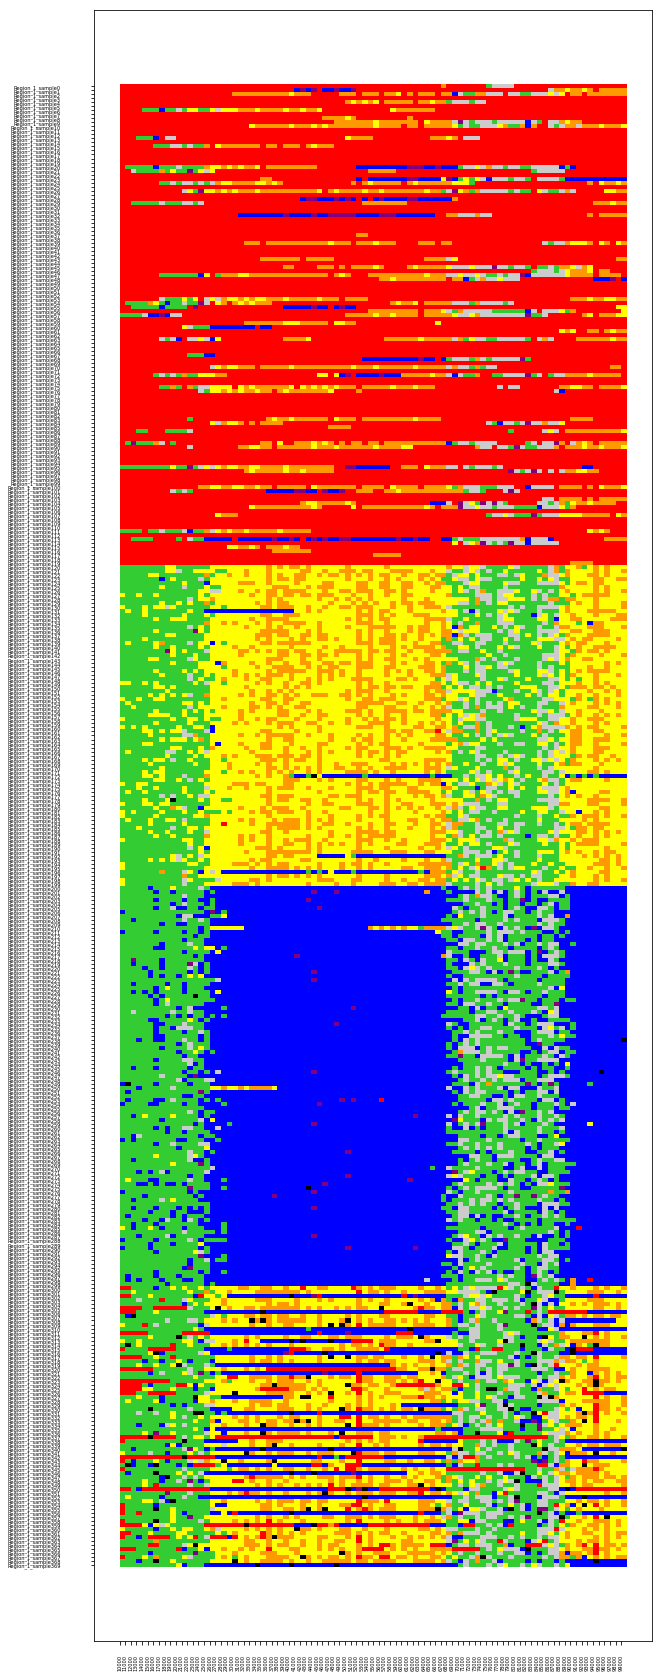

In [172]:
fig= return_ideogram(ideo_kde)

In [106]:
### Write LAMP-file

Refs= [1,2]
Admx= [3]
Home= 'LAMP-HAP_test'


def lamp_input(Out, Refs, Admx, haplotypes, Home):
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_lamp.pos"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(s) + '\n')
    posfile.close()
    
    for pop in Refs:
        filename= Home + "/pop{}.ref".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()
    
    for pop in Admx:
        filename= Home + "/pop{}.txt".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x*2) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()

import os
lamp_input(Out,Refs,Admx,haplotypes,Home)